In [67]:

import numpy as np
import random
from numpy import loadtxt
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

import scipy.special
from scipy.optimize import fmin
from tqdm import tqdm

# Load data

In [68]:
data = np.loadtxt("./results/critical-atom-numbers/recipe-7-nc/functionals_E_N.dat")
# the header is: a_s  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  alpha_opt  beta  gamma  min_energy  
# read all data
a_s = data[:,0]
n_c_best_possible_fit = data[:,1]
rho_min_x = data[:,2]
rho_max_x = data[:,3]
alpha = data[:,4]
alpha_opt = data[:,5]
beta = data[:,6]
gamma = data[:,7]

# Take only the data where rho_min_x is smaller than 0.8, and rho_max_x is larger than 2.0
indices = np.where((rho_min_x < 0.8) & (rho_min_x > 0.4) & (rho_max_x > 1.5) & (rho_max_x < 2.5))
a_s = a_s[indices]
n_c_best_possible_fit = n_c_best_possible_fit[indices]
rho_min_x = rho_min_x[indices]
rho_max_x = rho_max_x[indices]
alpha = alpha[indices]
alpha_opt = alpha_opt[indices]
beta = beta[indices]
gamma = gamma[indices]





In [69]:
set(rho_min_x), set(rho_max_x)

({0.5, 0.6, 0.7}, {1.7, 1.9, 2.1, 2.3})

In [70]:
for c in zip(rho_min_x, rho_max_x):
    print(c)

(0.5, 1.7)
(0.5, 1.7)
(0.5, 1.7)
(0.5, 1.7)
(0.5, 1.7)
(0.5, 1.9)
(0.5, 1.9)
(0.5, 1.9)
(0.5, 1.9)
(0.5, 1.9)
(0.5, 1.9)
(0.5, 2.1)
(0.5, 2.1)
(0.5, 2.1)
(0.5, 2.1)
(0.5, 2.1)
(0.5, 2.1)
(0.5, 2.3)
(0.5, 2.3)
(0.5, 2.3)
(0.5, 2.3)
(0.5, 2.3)
(0.5, 2.3)
(0.6, 1.7)
(0.6, 1.7)
(0.6, 1.7)
(0.6, 1.7)
(0.6, 1.7)
(0.6, 1.9)
(0.6, 1.9)
(0.6, 1.9)
(0.6, 1.9)
(0.6, 1.9)
(0.6, 1.9)
(0.6, 2.1)
(0.6, 2.1)
(0.6, 2.1)
(0.6, 2.1)
(0.6, 2.1)
(0.6, 2.1)
(0.6, 2.3)
(0.6, 2.3)
(0.6, 2.3)
(0.6, 2.3)
(0.6, 2.3)
(0.6, 2.3)
(0.7, 1.7)
(0.7, 1.7)
(0.7, 1.7)
(0.7, 1.7)
(0.7, 1.7)
(0.7, 1.7)
(0.7, 1.9)
(0.7, 1.9)
(0.7, 1.9)
(0.7, 1.9)
(0.7, 1.9)
(0.7, 1.9)
(0.7, 2.1)
(0.7, 2.1)
(0.7, 2.1)
(0.7, 2.1)
(0.7, 2.1)
(0.7, 2.1)
(0.7, 2.3)
(0.7, 2.3)
(0.7, 2.3)
(0.7, 2.3)
(0.7, 2.3)
(0.7, 2.3)


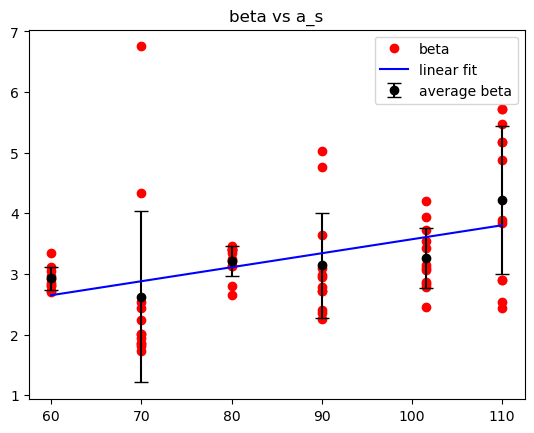

In [71]:
# Plot beta vs a_s
plt.plot(a_s, beta, 'o', label='beta', color='red')
# On the same plot, plot the error bar for each a_s
a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(beta[a_s==a_s_unique[i]])
    std[i] = np.std(beta[a_s==a_s_unique[i]])
# plot the error bar for each a_s, with larger error bars for a_s with less data points
plt.errorbar(a_s_unique, average, yerr=std, fmt='o', label='average beta', capsize=5, color='black')
# Make a linear fit of the average beta vs a_s
def func_beta(x, a, b):
    return a*x + b
popt_beta, pcov = curve_fit(func_beta, a_s_unique, average)
plt.plot(a_s_unique, func_beta(a_s_unique, *popt_beta), label='linear fit', color='blue')
plt.title("beta vs a_s")
plt.legend(loc='best')

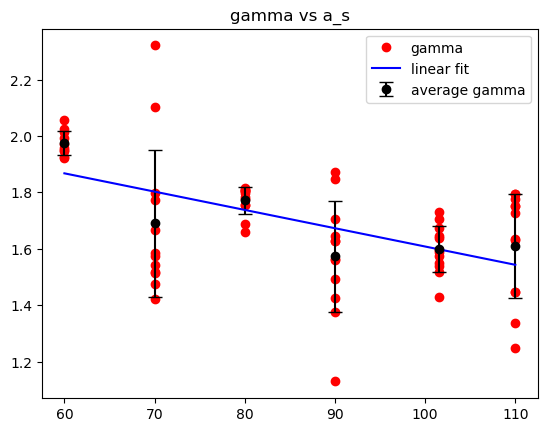

In [72]:
# Plot gamma vs a_s
plt.plot(a_s, gamma, 'o', label='gamma', color='red')
# On the same plot, plot the error bar for each a_s
a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(gamma[a_s==a_s_unique[i]])
    std[i] = np.std(gamma[a_s==a_s_unique[i]])
# plot the error bar for each a_s, with larger error bars for a_s with less data points
plt.errorbar(a_s_unique, average, yerr=std, fmt='o', label='average gamma', capsize=5, color='black')
# Make a linear fit of the average gamma vs a_s
def func_gamma(x, a, b):
    return a*x + b
popt_gamma, pcov = curve_fit(func_gamma, a_s_unique, average)
plt.plot(a_s_unique, func_gamma(a_s_unique, *popt_gamma), label='linear fit', color='blue')
plt.title("gamma vs a_s")
plt.legend(loc='best')

# Estimate $n_c$ for each $a_s$ value, using fits


In [73]:
from estimate_nc.estimate_nc import estimate_nc, en_per_particle

In [74]:
a_s = np.linspace(60, 110, 50)
r_0 = 387.6   # https://www.wolframalpha.com/input?i=%28162Dy+mass%29+*+%28mu_0%29+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# for each a_s, find the best possible fit for n_c, using the fits func_beta and func_gamma
n_c_best_possible_fit = np.zeros(len(a_s))
for i in tqdm(range(len(a_s))):
    alpha = 2*np.pi*(a_s[i]/r_0) # * (1 - 1 / (3*(a_s / r_0)))
    n_c_best_possible_fit[i] = estimate_nc(alpha,func_beta(a_s[i], *popt_beta), func_gamma(a_s[i], *popt_gamma), based_on="size")[0]


  0%|          | 0/50 [00:00<?, ?it/s]

nparticles: 285000.0, sr_local_min: [16.5246493  16.1240481  15.72344689 15.32284569 14.92224449 14.52164329
 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727 12.11803607
 11.71743487 11.31683367 10.91623246 10.51563126], sz_local_min: [ 609.28797595  637.34268537  669.40521042  701.46773547  737.53807615
  773.60841683  817.69438878  861.78036072  913.88196393  969.99138277
 1030.10861723 1098.24148297 1170.38216433 1254.54629259 1346.7260521
 1450.92925852]
nparticles: 270750.0, sr_local_min: [16.1240481  15.72344689 15.32284569 14.92224449 14.52164329 14.12104208
 13.72044088 13.31983968 12.91923848 12.51863727 12.11803607 11.71743487
 11.31683367 10.91623246 10.51563126], sz_local_min: [ 609.28797595  637.34268537  669.40521042  701.46773547  737.53807615
  777.61623246  821.70220441  869.79599198  921.89759519  978.00701403
 1042.13206413 1114.27274549 1194.42905812 1282.601002   1378.78857715]
nparticles: 257212.5, sr_local_min: [15.72344689 15.32284569 14.92224449 14.

  2%|▏         | 1/50 [00:04<03:26,  4.21s/it]

nparticles: 266.2288886817897, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  28.15470942 1631.28096192]
nparticles: 252.91744424770022, sr_local_min: [200.], sz_local_min: [1675.36693387]
nparticles: 285000.0, sr_local_min: [16.5246493  16.1240481  15.72344689 15.32284569 14.92224449 14.52164329
 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727 12.11803607
 11.71743487 11.31683367 10.91623246], sz_local_min: [ 633.33486974  661.38957916  693.45210421  725.51462926  761.58496994
  801.66312625  845.7490982   893.84288577  945.94448898 1002.05390782
 1066.17895792 1138.31963928 1214.46813627 1298.63226453 1394.81983968]
nparticles: 270750.0, sr_local_min: [16.5246493  16.1240481  15.72344689 15.32284569 14.92224449 14.52164329
 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727 12.11803607
 11.71743487 11.31683367 10.91623246], sz_local_min: [ 601.27234469  629.32705411  657.38176353  689.44428858  725.51462926
  765.59278557  805.67094188  849.75691383 

  4%|▍         | 2/50 [00:07<03:09,  3.95s/it]

nparticles: 294.99045837317425, sr_local_min: [  5.30781563   7.31082164 200.        ], sz_local_min: [  28.15470942   32.16252505 1567.15591182]
nparticles: 280.2409354545155, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  28.15470942 1607.23406814]
nparticles: 266.2288886817897, sr_local_min: [200.], sz_local_min: [1651.32004008]
nparticles: 285000.0, sr_local_min: [16.9252505  16.5246493  16.1240481  15.72344689 15.32284569 14.92224449
 14.52164329 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727
 12.11803607 11.71743487], sz_local_min: [ 625.31923848  653.3739479   685.43647295  717.498998    753.56933868
  789.63967936  829.71783567  877.81162325  925.90541082  982.01482966
 1042.13206413 1106.25711423 1178.39779559 1258.55410822]
nparticles: 270750.0, sr_local_min: [16.5246493  16.1240481  15.72344689 15.32284569 14.92224449 14.52164329
 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727 12.11803607
 11.71743487 11.31683367], sz_local_min: [ 625.3

  6%|▌         | 3/50 [00:11<03:03,  3.90s/it]

nparticles: 280.2409354545155, sr_local_min: [200.], sz_local_min: [1631.28096192]
nparticles: 285000.0, sr_local_min: [16.9252505  16.5246493  16.1240481  15.72344689 15.32284569 14.92224449
 14.52164329 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727
 12.11803607 11.71743487], sz_local_min: [ 649.36613226  677.42084168  709.48336673  741.54589178  777.61623246
  817.69438878  861.78036072  909.8741483   961.9757515  1018.08517034
 1078.20240481 1146.33527054 1222.48376754 1306.64789579]
nparticles: 270750.0, sr_local_min: [16.5246493  16.1240481  15.72344689 15.32284569 14.92224449 14.52164329
 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727 12.11803607
 11.71743487], sz_local_min: [ 645.35831663  677.42084168  709.48336673  741.54589178  781.6240481
  821.70220441  865.78817635  913.88196393  969.99138277 1026.1008016
 1090.2258517  1162.36653307 1242.52284569]
nparticles: 257212.5, sr_local_min: [16.5246493  16.1240481  15.72344689 15.32284569 14.92224449 14

  8%|▊         | 4/50 [00:15<02:55,  3.82s/it]

nparticles: 326.85923365448673, sr_local_min: [  5.30781563   6.10901804 200.        ], sz_local_min: [  28.15470942   32.16252505 1531.08557114]
nparticles: 310.51627197176236, sr_local_min: [200.], sz_local_min: [1567.15591182]
nparticles: 285000.0, sr_local_min: [16.9252505  16.5246493  16.1240481  15.72344689 15.32284569 14.92224449
 14.52164329 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727
 12.11803607], sz_local_min: [ 673.41302605  705.4755511   737.53807615  769.6006012   809.67875752
  849.75691383  893.84288577  945.94448898  998.04609218 1058.16332665
 1122.28837675 1190.42124248 1270.57755511]
nparticles: 270750.0, sr_local_min: [16.9252505  16.5246493  16.1240481  15.72344689 15.32284569 14.92224449
 14.52164329 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727
 12.11803607], sz_local_min: [ 641.350501    669.40521042  701.46773547  733.53026052  769.6006012
  809.67875752  853.76472946  897.8507014   949.95230461 1006.06172345
 1066.17895792 1134.3

 10%|█         | 5/50 [00:19<02:49,  3.77s/it]

nparticles: 344.0623512152492, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  32.16252505 1511.04649299]
nparticles: 326.85923365448673, sr_local_min: [200.], sz_local_min: [1551.1246493]
nparticles: 285000.0, sr_local_min: [17.3258517  16.9252505  16.5246493  16.1240481  15.72344689 15.32284569
 14.92224449 14.52164329 14.12104208 13.72044088 13.31983968 12.91923848
 12.51863727], sz_local_min: [ 669.40521042  697.45991984  729.52244489  765.59278557  801.66312625
  841.74128257  881.81943888  929.91322645  982.01482966 1038.1242485
 1098.24148297 1166.3743487  1238.51503006]
nparticles: 270750.0, sr_local_min: [17.3258517  16.9252505  16.5246493  16.1240481  15.72344689 15.32284569
 14.92224449 14.52164329 14.12104208 13.72044088 13.31983968 12.91923848
 12.51863727], sz_local_min: [ 637.34268537  665.39739479  697.45991984  729.52244489  761.58496994
  801.66312625  841.74128257  885.82725451  933.92104208  986.02264529
 1046.13987976 1106.25711423 1178.39779559]
nparti

 12%|█▏        | 6/50 [00:23<02:52,  3.92s/it]

nparticles: 362.17089601605176, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  32.16252505 1499.02304609]
nparticles: 344.0623512152492, sr_local_min: [200.], sz_local_min: [1535.09338677]
nparticles: 285000.0, sr_local_min: [17.3258517  16.9252505  16.5246493  16.1240481  15.72344689 15.32284569
 14.92224449 14.52164329 14.12104208 13.72044088 13.31983968 12.91923848], sz_local_min: [ 697.45991984  725.51462926  757.57715431  793.64749499  833.7256513
  873.80380762  917.88977956  965.98356713 1018.08517034 1078.20240481
 1142.32745491 1210.46032064]
nparticles: 270750.0, sr_local_min: [16.9252505  16.5246493  16.1240481  15.72344689 15.32284569 14.92224449
 14.52164329 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727], sz_local_min: [ 693.45210421  721.50681363  757.57715431  793.64749499  829.71783567
  873.80380762  921.89759519  969.99138277 1026.1008016  1086.21803607
 1150.34308617 1226.49158317]
nparticles: 257212.5, sr_local_min: [16.9252505  16.5246493

 14%|█▍        | 7/50 [00:26<02:43,  3.80s/it]

nparticles: 468.05352582888077, sr_local_min: [  5.30781563 200.        ], sz_local_min: [  36.17034068 1366.76513026]
nparticles: 444.6508495374367, sr_local_min: [  5.30781563   5.70841683 200.        ], sz_local_min: [  32.16252505   36.17034068 1390.81202405]
nparticles: 422.41830706056487, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  36.17034068 1422.8745491 ]
nparticles: 401.29739170753663, sr_local_min: [  5.70841683   6.50961924   7.71142285 200.        ], sz_local_min: [  32.16252505   36.17034068   40.17815631 1450.92925852]
nparticles: 381.23252212215976, sr_local_min: [  7.31082164 200.        ], sz_local_min: [  36.17034068 1482.99178357]
nparticles: 362.17089601605176, sr_local_min: [200.], sz_local_min: [1519.06212425]
nparticles: 285000.0, sr_local_min: [17.72645291 17.3258517  16.9252505  16.5246493  16.1240481  15.72344689
 15.32284569 14.92224449 14.52164329 14.12104208 13.72044088], sz_local_min: [ 693.45210421  725.51462926  753.56933868  789.6396793

 16%|█▌        | 8/50 [00:30<02:34,  3.67s/it]

nparticles: 492.6879219251377, sr_local_min: [  5.70841683 200.        ], sz_local_min: [  36.17034068 1358.749499  ]
nparticles: 468.05352582888077, sr_local_min: [  5.70841683 200.        ], sz_local_min: [  36.17034068 1382.79639279]
nparticles: 444.6508495374367, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  36.17034068 1410.8511022 ]
nparticles: 422.41830706056487, sr_local_min: [  6.50961924   7.31082164 200.        ], sz_local_min: [  36.17034068   40.17815631 1438.90581162]
nparticles: 401.29739170753663, sr_local_min: [  6.91022044 200.        ], sz_local_min: [  36.17034068 1470.96833667]
nparticles: 381.23252212215976, sr_local_min: [200.], sz_local_min: [1503.03086172]
nparticles: 285000.0, sr_local_min: [18.12705411 17.72645291 17.3258517  16.9252505  16.5246493  16.1240481
 15.72344689 15.32284569 14.92224449 14.52164329 14.12104208 13.72044088], sz_local_min: [ 693.45210421  721.50681363  753.56933868  785.63186373  821.70220441
  857.77254509  901.85851703

 18%|█▊        | 9/50 [00:33<02:26,  3.57s/it]

nparticles: 492.6879219251377, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  36.17034068 1374.78076152]
nparticles: 468.05352582888077, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  36.17034068 1402.83547094]
nparticles: 444.6508495374367, sr_local_min: [  6.50961924   7.31082164 200.        ], sz_local_min: [  36.17034068   40.17815631 1430.89018036]
nparticles: 422.41830706056487, sr_local_min: [200.], sz_local_min: [1462.95270541]
nparticles: 285000.0, sr_local_min: [18.12705411 17.72645291 17.3258517  16.9252505  16.5246493  16.1240481
 15.72344689 15.32284569 14.92224449 14.52164329 14.12104208], sz_local_min: [ 721.50681363  753.56933868  785.63186373  817.69438878  853.76472946
  893.84288577  937.92885772  986.02264529 1038.1242485  1090.2258517
 1154.3509018 ]
nparticles: 270750.0, sr_local_min: [17.72645291 17.3258517  16.9252505  16.5246493  16.1240481  15.72344689
 15.32284569 14.92224449 14.52164329 14.12104208], sz_local_min: [ 717.498998    74

 20%|██        | 10/50 [00:37<02:20,  3.52s/it]

nparticles: 468.05352582888077, sr_local_min: [  7.31082164 200.        ], sz_local_min: [  40.17815631 1422.8745491 ]
nparticles: 444.6508495374367, sr_local_min: [200.], sz_local_min: [1450.92925852]
nparticles: 285000.0, sr_local_min: [18.12705411 17.72645291 17.3258517  16.9252505  16.5246493  16.1240481
 15.72344689 15.32284569 14.92224449 14.52164329], sz_local_min: [ 753.56933868  785.63186373  817.69438878  853.76472946  893.84288577
  933.92104208  978.00701403 1030.10861723 1082.21022044 1138.31963928]
nparticles: 270750.0, sr_local_min: [18.12705411 17.72645291 17.3258517  16.9252505  16.5246493  16.1240481
 15.72344689 15.32284569 14.92224449 14.52164329], sz_local_min: [ 717.498998    749.56152305  777.61623246  813.68657315  849.75691383
  889.83507014  933.92104208  978.00701403 1030.10861723 1086.21803607]
nparticles: 257212.5, sr_local_min: [17.72645291 17.3258517  16.9252505  16.5246493  16.1240481  15.72344689
 15.32284569 14.92224449 14.52164329 14.12104208], sz_loc

 22%|██▏       | 11/50 [00:40<02:17,  3.52s/it]

nparticles: 604.8915179289758, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  40.17815631 1318.67134269]
nparticles: 574.6469420325269, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  40.17815631 1338.71042084]
nparticles: 545.9145949309005, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  40.17815631 1362.75731463]
nparticles: 518.6188651843555, sr_local_min: [  6.91022044   7.31082164   8.91322645 200.        ], sz_local_min: [  40.17815631   44.18597194   48.19378758 1390.81202405]
nparticles: 492.6879219251377, sr_local_min: [  8.51262525 200.        ], sz_local_min: [  44.18597194 1414.85891784]
nparticles: 468.05352582888077, sr_local_min: [200.], sz_local_min: [1442.91362725]
nparticles: 285000.0, sr_local_min: [18.52765531 18.12705411 17.72645291 17.3258517  16.9252505  16.5246493
 16.1240481  15.72344689 15.32284569 14.92224449], sz_local_min: [ 757.57715431  785.63186373  817.69438878  853.76472946  889.83507014
  929.91322645  973.9991984 

 24%|██▍       | 12/50 [00:43<02:11,  3.47s/it]

nparticles: 604.8915179289758, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  44.18597194 1338.71042084]
nparticles: 574.6469420325269, sr_local_min: [  6.91022044 200.        ], sz_local_min: [  44.18597194 1358.749499  ]
nparticles: 545.9145949309005, sr_local_min: [  7.31082164   8.51262525 200.        ], sz_local_min: [  44.18597194   48.19378758 1382.79639279]
nparticles: 518.6188651843555, sr_local_min: [200.], sz_local_min: [1410.8511022]
nparticles: 285000.0, sr_local_min: [18.52765531 18.12705411 17.72645291 17.3258517  16.9252505  16.5246493
 16.1240481  15.72344689 15.32284569], sz_local_min: [ 789.63967936  821.70220441  853.76472946  889.83507014  929.91322645
  973.9991984  1018.08517034 1070.18677355 1122.28837675]
nparticles: 270750.0, sr_local_min: [18.52765531 18.12705411 17.72645291 17.3258517  16.9252505  16.5246493
 16.1240481  15.72344689 15.32284569], sz_local_min: [ 753.56933868  781.6240481   813.68657315  849.75691383  885.82725451
  925.90541082 

 26%|██▌       | 13/50 [00:47<02:06,  3.41s/it]

nparticles: 705.5156937500813, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  44.18597194 1294.6244489 ]
nparticles: 670.2399090625771, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  44.18597194 1314.66352705]
nparticles: 636.7279136094483, sr_local_min: [  6.91022044   7.31082164 200.        ], sz_local_min: [  44.18597194   48.19378758 1334.70260521]
nparticles: 604.8915179289758, sr_local_min: [  7.31082164   7.71142285 200.        ], sz_local_min: [  44.18597194   48.19378758 1354.74168337]
nparticles: 574.6469420325269, sr_local_min: [  8.51262525 200.        ], sz_local_min: [  48.19378758 1378.78857715]
nparticles: 545.9145949309005, sr_local_min: [200.], sz_local_min: [1402.83547094]
nparticles: 285000.0, sr_local_min: [18.92825651 18.52765531 18.12705411 17.72645291 17.3258517  16.9252505
 16.5246493  16.1240481  15.72344689], sz_local_min: [ 793.64749499  825.71002004  857.77254509  893.84288577  933.92104208
  973.9991984  1018.08517034 1066.1789579

 28%|██▊       | 14/50 [00:50<02:02,  3.39s/it]

nparticles: 670.2399090625771, sr_local_min: [  7.31082164 200.        ], sz_local_min: [  48.19378758 1334.70260521]
nparticles: 636.7279136094483, sr_local_min: [  7.71142285   8.51262525  10.11503006 200.        ], sz_local_min: [  48.19378758   52.20160321   56.20941884 1354.74168337]
nparticles: 604.8915179289758, sr_local_min: [200.], sz_local_min: [1378.78857715]
nparticles: 285000.0, sr_local_min: [19.32885772 18.92825651 18.52765531 18.12705411 17.72645291 17.3258517
 16.9252505  16.5246493  16.1240481 ], sz_local_min: [ 801.66312625  829.71783567  861.78036072  897.8507014   937.92885772
  978.00701403 1018.08517034 1066.17895792 1118.28056112]
nparticles: 270750.0, sr_local_min: [18.92825651 18.52765531 18.12705411 17.72645291 17.3258517  16.9252505
 16.5246493  16.1240481 ], sz_local_min: [ 793.64749499  821.70220441  857.77254509  889.83507014  929.91322645
  969.99138277 1014.07735471 1062.17114228]
nparticles: 257212.5, sr_local_min: [18.92825651 18.52765531 18.12705411 

 30%|███       | 15/50 [00:54<02:00,  3.45s/it]

nparticles: 866.1881891637804, sr_local_min: [  6.91022044 200.        ], sz_local_min: [  52.20160321 1262.56192385]
nparticles: 822.8787797055913, sr_local_min: [  6.91022044 200.        ], sz_local_min: [  52.20160321 1278.59318637]
nparticles: 781.7348407203117, sr_local_min: [  7.31082164 200.        ], sz_local_min: [  52.20160321 1294.6244489 ]
nparticles: 742.6480986842961, sr_local_min: [  7.71142285 200.        ], sz_local_min: [  52.20160321 1314.66352705]
nparticles: 705.5156937500813, sr_local_min: [  8.11202405 200.        ], sz_local_min: [  52.20160321 1334.70260521]
nparticles: 670.2399090625771, sr_local_min: [  8.51262525   9.71442886 200.        ], sz_local_min: [  52.20160321   56.20941884 1354.74168337]
nparticles: 636.7279136094483, sr_local_min: [200.], sz_local_min: [1374.78076152]
nparticles: 285000.0, sr_local_min: [19.72945892 19.32885772 18.92825651 18.52765531 18.12705411 17.72645291
 17.3258517  16.9252505 ], sz_local_min: [ 809.67875752  837.73346693  86

 32%|███▏      | 16/50 [00:57<01:58,  3.50s/it]

nparticles: 705.5156937500813, sr_local_min: [  8.51262525   9.71442886 200.        ], sz_local_min: [  52.20160321   56.20941884 1354.74168337]
nparticles: 670.2399090625771, sr_local_min: [200.], sz_local_min: [1374.78076152]
nparticles: 285000.0, sr_local_min: [20.13006012 19.72945892 19.32885772 18.92825651 18.52765531 18.12705411
 17.72645291 17.3258517 ], sz_local_min: [ 817.69438878  849.75691383  877.81162325  913.88196393  949.95230461
  990.03046092 1030.10861723 1074.19458918]
nparticles: 270750.0, sr_local_min: [19.72945892 19.32885772 18.92825651 18.52765531 18.12705411 17.72645291
 17.3258517  16.9252505 ], sz_local_min: [ 809.67875752  837.73346693  869.79599198  905.86633267  941.93667335
  982.01482966 1022.09298597 1070.18677355]
nparticles: 257212.5, sr_local_min: [19.32885772 18.92825651 18.52765531 18.12705411 17.72645291 17.3258517
 16.9252505  16.5246493 ], sz_local_min: [ 801.66312625  829.71783567  861.78036072  897.8507014   933.92104208
  973.9991984  1018.08

 34%|███▍      | 17/50 [01:00<01:51,  3.39s/it]

nparticles: 1010.2792700554371, sr_local_min: [  7.31082164 200.        ], sz_local_min: [  56.20941884 1254.54629259]
nparticles: 959.7653065526653, sr_local_min: [  7.71142285 200.        ], sz_local_min: [  56.20941884 1270.57755511]
nparticles: 911.777041225032, sr_local_min: [  7.71142285 200.        ], sz_local_min: [  56.20941884 1282.601002  ]
nparticles: 866.1881891637804, sr_local_min: [  8.11202405 200.        ], sz_local_min: [  56.20941884 1302.64008016]
nparticles: 822.8787797055913, sr_local_min: [  8.11202405 200.        ], sz_local_min: [  56.20941884 1318.67134269]
nparticles: 781.7348407203117, sr_local_min: [  8.91322645   9.71442886  10.91623246 200.        ], sz_local_min: [  56.20941884   60.21723447   64.2250501  1334.70260521]
nparticles: 742.6480986842961, sr_local_min: [200.], sz_local_min: [1354.74168337]
nparticles: 285000.0, sr_local_min: [20.53066132 20.13006012 19.72945892 19.32885772 18.92825651 18.52765531
 18.12705411 17.72645291], sz_local_min: [ 829

 36%|███▌      | 18/50 [01:05<01:54,  3.59s/it]

nparticles: 781.7348407203117, sr_local_min: [200.], sz_local_min: [1358.749499]
nparticles: 285000.0, sr_local_min: [20.93126253 20.53066132 20.13006012 19.72945892 19.32885772 18.92825651
 18.52765531 18.12705411], sz_local_min: [ 841.74128257  873.80380762  901.85851703  937.92885772  969.99138277
 1010.06953908 1050.14769539 1094.23366733]
nparticles: 270750.0, sr_local_min: [20.53066132 20.13006012 19.72945892 19.32885772 18.92825651 18.52765531
 18.12705411 17.72645291], sz_local_min: [ 833.7256513   861.78036072  893.84288577  925.90541082  961.9757515
  998.04609218 1042.13206413 1086.21803607]
nparticles: 257212.5, sr_local_min: [20.13006012 19.72945892 19.32885772 18.92825651 18.52765531 18.12705411
 17.72645291], sz_local_min: [ 821.70220441  849.75691383  881.81943888  917.88977956  953.96012024
  990.03046092 1034.11643287]
nparticles: 244351.875, sr_local_min: [19.72945892 19.32885772 18.92825651 18.52765531 18.12705411 17.72645291], sz_local_min: [813.68657315 841.741282

 38%|███▊      | 19/50 [01:08<01:48,  3.49s/it]

nparticles: 1119.4230139118417, sr_local_min: [  8.11202405 200.        ], sz_local_min: [  64.2250501  1266.56973948]
nparticles: 1063.4518632162496, sr_local_min: [  8.51262525 200.        ], sz_local_min: [  64.2250501  1278.59318637]
nparticles: 1010.2792700554371, sr_local_min: [  8.51262525 200.        ], sz_local_min: [  64.2250501 1294.6244489]
nparticles: 959.7653065526653, sr_local_min: [  8.91322645 200.        ], sz_local_min: [  64.2250501  1310.65571142]
nparticles: 911.777041225032, sr_local_min: [  9.71442886  10.51563126  12.11803607 200.        ], sz_local_min: [  64.2250501    68.23286573   72.24068136 1326.68697395]
nparticles: 866.1881891637804, sr_local_min: [200.], sz_local_min: [1342.71823647]
nparticles: 285000.0, sr_local_min: [21.33186373 20.93126253 20.53066132 20.13006012 19.72945892 19.32885772
 18.92825651 18.52765531], sz_local_min: [ 857.77254509  885.82725451  917.88977956  949.95230461  986.02264529
 1022.09298597 1062.17114228 1106.25711423]
nparticl

 40%|████      | 20/50 [01:12<01:50,  3.67s/it]

nparticles: 1063.4518632162496, sr_local_min: [  8.91322645   9.31382766 200.        ], sz_local_min: [  64.2250501    68.23286573 1302.64008016]
nparticles: 1010.2792700554371, sr_local_min: [  9.31382766   9.71442886  13.72044088 200.        ], sz_local_min: [  64.2250501    68.23286573   80.25631263 1314.66352705]
nparticles: 959.7653065526653, sr_local_min: [ 10.51563126 200.        ], sz_local_min: [  68.23286573 1330.69478958]
nparticles: 911.777041225032, sr_local_min: [200.], sz_local_min: [1346.7260521]
nparticles: 285000.0, sr_local_min: [21.33186373 20.93126253 20.53066132 20.13006012 19.72945892 19.32885772
 18.92825651], sz_local_min: [ 905.86633267  933.92104208  965.98356713 1002.05390782 1038.1242485
 1078.20240481 1122.28837675]
nparticles: 270750.0, sr_local_min: [21.33186373 20.93126253 20.53066132 20.13006012 19.72945892 19.32885772
 18.92825651], sz_local_min: [ 861.78036072  893.84288577  921.89759519  953.96012024  990.03046092
 1026.1008016  1066.17895792]
npart

 42%|████▏     | 21/50 [01:15<01:44,  3.60s/it]

nparticles: 1119.4230139118417, sr_local_min: [  9.71442886  10.11503006  14.92224449 200.        ], sz_local_min: [  68.23286573   72.24068136   88.27194389 1310.65571142]
nparticles: 1063.4518632162496, sr_local_min: [ 10.51563126  11.71743487  12.91923848 200.        ], sz_local_min: [  72.24068136   76.24849699   80.25631263 1322.67915832]
nparticles: 1010.2792700554371, sr_local_min: [200.], sz_local_min: [1338.71042084]
nparticles: 285000.0, sr_local_min: [22.13306613 21.73246493 21.33186373 20.93126253 20.53066132 20.13006012
 19.72945892], sz_local_min: [ 893.84288577  925.90541082  953.96012024  986.02264529 1022.09298597
 1058.16332665 1098.24148297]
nparticles: 270750.0, sr_local_min: [21.73246493 21.33186373 20.93126253 20.53066132 20.13006012 19.72945892
 19.32885772], sz_local_min: [ 881.81943888  909.8741483   941.93667335  973.9991984  1010.06953908
 1046.13987976 1086.21803607]
nparticles: 257212.5, sr_local_min: [21.33186373 20.93126253 20.53066132 20.13006012 19.7294

 44%|████▍     | 22/50 [01:19<01:38,  3.53s/it]

nparticles: 1522.8341220851594, sr_local_min: [  9.31382766 200.        ], sz_local_min: [  76.24849699 1258.55410822]
nparticles: 1446.6924159809014, sr_local_min: [  9.31382766 200.        ], sz_local_min: [  76.24849699 1270.57755511]
nparticles: 1374.3577951818563, sr_local_min: [  9.31382766 200.        ], sz_local_min: [  76.24849699 1278.59318637]
nparticles: 1305.6399054227634, sr_local_min: [  9.71442886 200.        ], sz_local_min: [  76.24849699 1290.61663327]
nparticles: 1240.3579101516252, sr_local_min: [  9.71442886  10.11503006  15.32284569 200.        ], sz_local_min: [  72.24068136   76.24849699   96.28757515 1302.64008016]
nparticles: 1178.340014644044, sr_local_min: [ 10.91623246  14.12104208 200.        ], sz_local_min: [  76.24849699   88.27194389 1318.67134269]
nparticles: 1119.4230139118417, sr_local_min: [200.], sz_local_min: [1330.69478958]
nparticles: 285000.0, sr_local_min: [22.53366733 22.13306613 21.73246493 21.33186373 20.93126253 20.53066132
 20.13006012]

 46%|████▌     | 23/50 [01:22<01:31,  3.38s/it]

nparticles: 1602.983286405431, sr_local_min: [  9.71442886 200.        ], sz_local_min: [  80.25631263 1270.57755511]
nparticles: 1522.8341220851594, sr_local_min: [  9.71442886 200.        ], sz_local_min: [  80.25631263 1282.601002  ]
nparticles: 1446.6924159809014, sr_local_min: [ 10.11503006 200.        ], sz_local_min: [  80.25631263 1290.61663327]
nparticles: 1374.3577951818563, sr_local_min: [ 10.51563126 200.        ], sz_local_min: [  80.25631263 1302.64008016]
nparticles: 1305.6399054227634, sr_local_min: [ 10.91623246 200.        ], sz_local_min: [  80.25631263 1314.66352705]
nparticles: 1240.3579101516252, sr_local_min: [ 11.71743487  12.51863727 200.        ], sz_local_min: [  80.25631263   84.26412826 1326.68697395]
nparticles: 1178.340014644044, sr_local_min: [200.], sz_local_min: [1338.71042084]
nparticles: 285000.0, sr_local_min: [22.93426854 22.53366733 22.13306613 21.73246493 21.33186373 20.93126253], sz_local_min: [ 941.93667335  969.99138277 1002.05390782 1034.1164

 48%|████▊     | 24/50 [01:25<01:24,  3.25s/it]

nparticles: 1374.3577951818563, sr_local_min: [ 11.71743487  12.51863727  13.31983968  14.52164329 200.        ], sz_local_min: [  84.26412826   88.27194389   92.27975952   96.28757515 1326.68697395]
nparticles: 1305.6399054227634, sr_local_min: [200.], sz_local_min: [1338.71042084]
nparticles: 285000.0, sr_local_min: [23.33486974 22.93426854 22.53366733 22.13306613 21.73246493 21.33186373], sz_local_min: [ 969.99138277  998.04609218 1030.10861723 1062.17114228 1094.23366733
 1134.31182365]
nparticles: 270750.0, sr_local_min: [22.93426854 22.53366733 22.13306613 21.73246493 21.33186373], sz_local_min: [ 953.96012024  982.01482966 1014.07735471 1046.13987976 1082.21022044]
nparticles: 257212.5, sr_local_min: [22.93426854 22.53366733 22.13306613 21.73246493 21.33186373 20.93126253], sz_local_min: [ 909.8741483   937.92885772  965.98356713  998.04609218 1030.10861723
 1066.17895792]
nparticles: 244351.875, sr_local_min: [22.53366733 22.13306613 21.73246493 21.33186373 20.93126253], sz_loc

 50%|█████     | 25/50 [01:28<01:19,  3.16s/it]

nparticles: 1968.0429541276467, sr_local_min: [ 10.51563126 200.        ], sz_local_min: [  92.27975952 1278.59318637]
nparticles: 1869.6408064212642, sr_local_min: [ 10.51563126 200.        ], sz_local_min: [  92.27975952 1286.60881764]
nparticles: 1776.1587661002009, sr_local_min: [ 10.91623246 200.        ], sz_local_min: [  92.27975952 1294.6244489 ]
nparticles: 1687.3508277951908, sr_local_min: [ 10.91623246  11.31683367 200.        ], sz_local_min: [  88.27194389   92.27975952 1306.64789579]
nparticles: 1602.983286405431, sr_local_min: [ 11.31683367  11.71743487  18.12705411 200.        ], sz_local_min: [  88.27194389   92.27975952  116.32665331 1314.66352705]
nparticles: 1522.8341220851594, sr_local_min: [ 12.51863727 200.        ], sz_local_min: [  92.27975952 1326.68697395]
nparticles: 1446.6924159809014, sr_local_min: [200.], sz_local_min: [1338.71042084]
nparticles: 285000.0, sr_local_min: [24.13607214 23.73547094 23.33486974 22.93426854 22.53366733 22.13306613], sz_local_mi

 52%|█████▏    | 26/50 [01:30<01:13,  3.08s/it]

nparticles: 1522.8341220851594, sr_local_min: [200.], sz_local_min: [1350.73386774]
nparticles: 285000.0, sr_local_min: [24.53667335 24.13607214 23.73547094 23.33486974 22.93426854], sz_local_min: [1006.06172345 1034.11643287 1062.17114228 1094.23366733 1126.29619238]
nparticles: 270750.0, sr_local_min: [24.13607214 23.73547094 23.33486974 22.93426854 22.53366733], sz_local_min: [ 986.02264529 1014.07735471 1042.13206413 1074.19458918 1110.26492986]
nparticles: 257212.5, sr_local_min: [23.73547094 23.33486974 22.93426854 22.53366733 22.13306613], sz_local_min: [ 969.99138277  998.04609218 1026.1008016  1058.16332665 1090.2258517 ]
nparticles: 244351.875, sr_local_min: [23.73547094 23.33486974 22.93426854 22.53366733 22.13306613], sz_local_min: [ 925.90541082  953.96012024  982.01482966 1010.06953908 1042.13206413]
nparticles: 232134.28125, sr_local_min: [23.33486974 22.93426854 22.53366733 22.13306613 21.73246493], sz_local_min: [ 909.8741483   937.92885772  965.98356713  994.03827655 

 54%|█████▍    | 27/50 [01:33<01:08,  3.00s/it]

nparticles: 1687.3508277951908, sr_local_min: [200.], sz_local_min: [1354.74168337]
nparticles: 285000.0, sr_local_min: [24.93727455 24.53667335 24.13607214 23.73547094 23.33486974], sz_local_min: [1042.13206413 1070.18677355 1098.24148297 1130.30400802 1166.3743487 ]
nparticles: 270750.0, sr_local_min: [24.93727455 24.53667335 24.13607214 23.73547094 23.33486974], sz_local_min: [ 994.03827655 1022.09298597 1050.14769539 1078.20240481 1110.26492986]
nparticles: 257212.5, sr_local_min: [24.53667335 24.13607214 23.73547094 23.33486974 22.93426854], sz_local_min: [ 973.9991984  1002.05390782 1030.10861723 1062.17114228 1094.23366733]
nparticles: 244351.875, sr_local_min: [24.13607214 23.73547094 23.33486974 22.93426854], sz_local_min: [ 957.96793587  986.02264529 1014.07735471 1042.13206413]
nparticles: 232134.28125, sr_local_min: [23.73547094 23.33486974 22.93426854 22.53366733], sz_local_min: [ 941.93667335  969.99138277  998.04609218 1026.1008016 ]
nparticles: 220527.56718749998, sr_lo

 56%|█████▌    | 28/50 [01:36<01:03,  2.90s/it]

nparticles: 2180.6570128838193, sr_local_min: [ 12.91923848  13.31983968 200.        ], sz_local_min: [ 108.31102204  112.31883768 1334.70260521]
nparticles: 2071.6241622396283, sr_local_min: [ 13.31983968  13.72044088  19.32885772 200.        ], sz_local_min: [ 108.31102204  112.31883768  136.36573146 1342.71823647]
nparticles: 1968.0429541276467, sr_local_min: [ 14.92224449  15.32284569  16.5246493   17.72645291 200.        ], sz_local_min: [ 112.31883768  116.32665331  120.33446894  124.34228457 1350.73386774]
nparticles: 1869.6408064212642, sr_local_min: [200.], sz_local_min: [1358.749499]
nparticles: 285000.0, sr_local_min: [25.73847695 25.33787575 24.93727455 24.53667335 24.13607214], sz_local_min: [1054.15551102 1082.21022044 1110.26492986 1142.32745491 1174.38997996]
nparticles: 270750.0, sr_local_min: [25.33787575 24.93727455 24.53667335 24.13607214 23.73547094], sz_local_min: [1034.11643287 1058.16332665 1090.2258517  1118.28056112 1154.3509018 ]
nparticles: 257212.5, sr_loca

 58%|█████▊    | 29/50 [01:39<01:00,  2.86s/it]

nparticles: 2071.6241622396283, sr_local_min: [200.], sz_local_min: [1366.76513026]
nparticles: 285000.0, sr_local_min: [26.53967936 26.13907816 25.73847695 25.33787575 24.93727455], sz_local_min: [1070.18677355 1098.24148297 1126.29619238 1154.3509018  1186.41342685]
nparticles: 270750.0, sr_local_min: [26.13907816 25.73847695 25.33787575 24.93727455 24.53667335], sz_local_min: [1050.14769539 1074.19458918 1102.2492986  1134.31182365 1166.3743487 ]
nparticles: 257212.5, sr_local_min: [25.73847695 25.33787575 24.93727455 24.53667335], sz_local_min: [1026.1008016  1054.15551102 1082.21022044 1110.26492986]
nparticles: 244351.875, sr_local_min: [25.73847695 25.33787575 24.93727455 24.53667335 24.13607214], sz_local_min: [ 982.01482966 1006.06172345 1034.11643287 1062.17114228 1090.2258517 ]
nparticles: 232134.28125, sr_local_min: [24.93727455 24.53667335 24.13607214 23.73547094], sz_local_min: [ 990.03046092 1014.07735471 1042.13206413 1074.19458918]
nparticles: 220527.56718749998, sr_lo

 60%|██████    | 30/50 [01:41<00:55,  2.78s/it]

nparticles: 3286.9910392218158, sr_local_min: [ 13.31983968 200.        ], sz_local_min: [ 132.35791583 1334.70260521]
nparticles: 3122.6414872607247, sr_local_min: [ 13.31983968 200.        ], sz_local_min: [ 128.3501002  1338.71042084]
nparticles: 2966.5094128976884, sr_local_min: [ 13.72044088 200.        ], sz_local_min: [ 128.3501002  1342.71823647]
nparticles: 2818.1839422528037, sr_local_min: [ 14.12104208 200.        ], sz_local_min: [ 128.3501002  1350.73386774]
nparticles: 2677.2747451401633, sr_local_min: [ 14.12104208  14.52164329 200.        ], sz_local_min: [ 124.34228457  128.3501002  1358.749499  ]
nparticles: 2543.411007883155, sr_local_min: [ 15.32284569  22.13306613 200.        ], sz_local_min: [ 128.3501002   160.41262525 1362.75731463]
nparticles: 2416.240457488997, sr_local_min: [ 16.1240481   16.5246493   17.3258517   18.12705411  19.32885772
 200.        ], sz_local_min: [ 128.3501002   132.35791583  136.36573146  140.37354709  144.38136273
 1370.77294589]
npart

 62%|██████▏   | 31/50 [01:44<00:51,  2.71s/it]

nparticles: 3286.9910392218158, sr_local_min: [ 14.52164329 200.        ], sz_local_min: [ 140.37354709 1358.749499  ]
nparticles: 3122.6414872607247, sr_local_min: [ 14.92224449 200.        ], sz_local_min: [ 136.36573146 1366.76513026]
nparticles: 2966.5094128976884, sr_local_min: [ 15.32284569 200.        ], sz_local_min: [ 136.36573146 1370.77294589]
nparticles: 2818.1839422528037, sr_local_min: [ 15.72344689 200.        ], sz_local_min: [ 136.36573146 1378.78857715]
nparticles: 2677.2747451401633, sr_local_min: [ 17.3258517   17.72645291  18.52765531  20.93126253 200.        ], sz_local_min: [ 140.37354709  144.38136273  148.38917836  156.40480962 1382.79639279]
nparticles: 2543.411007883155, sr_local_min: [200.], sz_local_min: [1390.81202405]
nparticles: 285000.0, sr_local_min: [27.74148297 27.34088176 26.94028056], sz_local_min: [1142.32745491 1170.38216433 1198.43687375]
nparticles: 270750.0, sr_local_min: [27.74148297 27.34088176 26.94028056 26.53967936], sz_local_min: [1094.2

 64%|██████▍   | 32/50 [01:46<00:47,  2.66s/it]

nparticles: 3122.6414872607247, sr_local_min: [ 16.9252505 200.       ], sz_local_min: [ 148.38917836 1394.81983968]
nparticles: 2966.5094128976884, sr_local_min: [ 18.52765531  18.92825651  19.72945892  20.93126253 200.        ], sz_local_min: [ 152.39699399  156.40480962  160.41262525  164.42044088 1398.82765531]
nparticles: 2818.1839422528037, sr_local_min: [200.], sz_local_min: [1406.84328657]
nparticles: 285000.0, sr_local_min: [28.94328657 28.54268537 28.14208417 27.74148297], sz_local_min: [1146.33527054 1174.38997996 1198.43687375 1226.49158317]
nparticles: 270750.0, sr_local_min: [28.54268537 28.14208417 27.74148297 27.34088176], sz_local_min: [1122.28837675 1146.33527054 1174.38997996 1202.44468938]
nparticles: 257212.5, sr_local_min: [28.14208417 27.74148297 27.34088176 26.94028056], sz_local_min: [1098.24148297 1122.28837675 1150.34308617 1178.39779559]
nparticles: 244351.875, sr_local_min: [27.74148297 27.34088176 26.94028056 26.53967936], sz_local_min: [1074.19458918 1098

 66%|██████▌   | 33/50 [01:49<00:45,  2.66s/it]

nparticles: 3459.9905676019116, sr_local_min: [ 18.12705411  18.52765531  26.53967936 200.        ], sz_local_min: [ 160.41262525  164.42044088  200.49078156 1410.8511022 ]
nparticles: 3286.9910392218158, sr_local_min: [ 19.72945892  20.53066132  20.93126253  22.13306613 200.        ], sz_local_min: [ 164.42044088  168.42825651  172.43607214  176.44388778 1418.86673347]
nparticles: 3122.6414872607247, sr_local_min: [200.], sz_local_min: [1422.8745491]
nparticles: 285000.0, sr_local_min: [29.74448898 29.34388778 28.94328657 28.54268537], sz_local_min: [1182.40561122 1210.46032064 1234.50721443 1262.56192385]
nparticles: 270750.0, sr_local_min: [29.34388778 28.94328657 28.54268537], sz_local_min: [1158.35871743 1182.40561122 1206.45250501]
nparticles: 257212.5, sr_local_min: [28.94328657 28.54268537 28.14208417], sz_local_min: [1130.30400802 1154.3509018  1182.40561122]
nparticles: 244351.875, sr_local_min: [28.94328657 28.54268537 28.14208417 27.74148297], sz_local_min: [1082.21022044 1

 68%|██████▊   | 34/50 [01:51<00:41,  2.57s/it]

nparticles: 3833.784562439792, sr_local_min: [ 19.72945892  26.94028056 200.        ], sz_local_min: [ 176.44388778  212.51422846 1430.89018036]
nparticles: 3642.095334317802, sr_local_min: [200.], sz_local_min: [1434.89799599]
nparticles: 285000.0, sr_local_min: [30.54569138 30.14509018 29.74448898], sz_local_min: [1226.49158317 1250.53847695 1278.59318637]
nparticles: 270750.0, sr_local_min: [30.54569138 30.14509018 29.74448898 29.34388778], sz_local_min: [1174.38997996 1198.43687375 1222.48376754 1246.53066132]
nparticles: 257212.5, sr_local_min: [30.14509018 29.74448898 29.34388778 28.94328657], sz_local_min: [1146.33527054 1170.38216433 1194.42905812 1222.48376754]
nparticles: 244351.875, sr_local_min: [29.74448898 29.34388778 28.94328657], sz_local_min: [1122.28837675 1142.32745491 1170.38216433]
nparticles: 232134.28125, sr_local_min: [29.34388778 28.94328657 28.54268537], sz_local_min: [1094.23366733 1118.28056112 1142.32745491]
nparticles: 220527.56718749998, sr_local_min: [28

 70%|███████   | 35/50 [01:54<00:37,  2.49s/it]

nparticles: 5215.381384741137, sr_local_min: [ 18.12705411 200.        ], sz_local_min: [ 192.4751503  1438.90581162]
nparticles: 4954.61231550408, sr_local_min: [ 18.52765531 200.        ], sz_local_min: [ 188.46733467 1438.90581162]
nparticles: 4706.881699728875, sr_local_min: [ 18.92825651 200.        ], sz_local_min: [ 188.46733467 1442.91362725]
nparticles: 4471.537614742431, sr_local_min: [ 19.72945892  31.74749499 200.        ], sz_local_min: [ 188.46733467  248.58456914 1450.92925852]
nparticles: 4247.96073400531, sr_local_min: [ 21.33186373  21.73246493  27.34088176 200.        ], sz_local_min: [ 192.4751503   196.48296593  224.53767535 1454.93707415]
nparticles: 4035.5626973050444, sr_local_min: [200.], sz_local_min: [1458.94488978]
nparticles: 285000.0, sr_local_min: [31.74749499 31.34689379 30.94629259], sz_local_min: [1246.53066132 1274.58537074 1298.63226453]
nparticles: 270750.0, sr_local_min: [31.34689379 30.94629259 30.54569138], sz_local_min: [1218.4759519  1242.52284

 72%|███████▏  | 36/50 [01:56<00:34,  2.50s/it]

nparticles: 6082.964146075098, sr_local_min: [ 18.92825651 200.        ], sz_local_min: [ 208.50641283 1458.94488978]
nparticles: 5778.815938771343, sr_local_min: [ 19.32885772 200.        ], sz_local_min: [ 208.50641283 1462.95270541]
nparticles: 5489.875141832776, sr_local_min: [ 19.72945892  20.13006012 200.        ], sz_local_min: [ 204.49859719  208.50641283 1466.96052104]
nparticles: 5215.381384741137, sr_local_min: [ 20.53066132 200.        ], sz_local_min: [ 204.49859719 1470.96833667]
nparticles: 4954.61231550408, sr_local_min: [ 21.33186373  21.73246493 200.        ], sz_local_min: [ 204.49859719  208.50641283 1474.9761523 ]
nparticles: 4706.881699728875, sr_local_min: [ 23.33486974  23.73547094  26.94028056  28.14208417 200.        ], sz_local_min: [ 212.51422846  216.52204409  232.55330661  236.56112224 1478.98396794]
nparticles: 4471.537614742431, sr_local_min: [200.], sz_local_min: [1482.99178357]
nparticles: 285000.0, sr_local_min: [32.9492986  32.54869739 32.14809619], 

 74%|███████▍  | 37/50 [01:59<00:32,  2.48s/it]

nparticles: 7094.869976468989, sr_local_min: [ 20.13006012 200.        ], sz_local_min: [ 232.55330661 1482.99178357]
nparticles: 6740.126477645539, sr_local_min: [ 20.53066132 200.        ], sz_local_min: [ 228.54549098 1486.9995992 ]
nparticles: 6403.120153763261, sr_local_min: [ 20.93126253 200.        ], sz_local_min: [ 224.53767535 1491.00741483]
nparticles: 6082.964146075098, sr_local_min: [ 21.33186373 200.        ], sz_local_min: [ 224.53767535 1495.01523046]
nparticles: 5778.815938771343, sr_local_min: [ 22.13306613 200.        ], sz_local_min: [ 224.53767535 1499.02304609]
nparticles: 5489.875141832776, sr_local_min: [ 23.73547094 200.        ], sz_local_min: [ 228.54549098 1499.02304609]
nparticles: 5215.381384741137, sr_local_min: [200.], sz_local_min: [1503.03086172]
nparticles: 285000.0, sr_local_min: [34.1511022 33.750501  33.3498998], sz_local_min: [1318.67134269 1342.71823647 1366.76513026]
nparticles: 270750.0, sr_local_min: [33.750501  33.3498998], sz_local_min: [128

 76%|███████▌  | 38/50 [02:01<00:28,  2.38s/it]

nparticles: 7094.869976468989, sr_local_min: [ 22.53366733 200.        ], sz_local_min: [ 248.58456914 1519.06212425]
nparticles: 6740.126477645539, sr_local_min: [ 23.33486974 200.        ], sz_local_min: [ 244.57675351 1523.06993988]
nparticles: 6403.120153763261, sr_local_min: [ 24.13607214  24.53667335  37.75651303 200.        ], sz_local_min: [ 244.57675351  248.58456914  320.7252505  1527.07775551]
nparticles: 6082.964146075098, sr_local_min: [ 26.13907816  26.53967936  32.54869739 200.        ], sz_local_min: [ 252.59238477  256.6002004   288.66272545 1531.08557114]
nparticles: 5778.815938771343, sr_local_min: [200.], sz_local_min: [1535.09338677]
nparticles: 285000.0, sr_local_min: [35.75350701 35.35290581 34.95230461], sz_local_min: [1342.71823647 1366.76513026 1386.80420842]
nparticles: 270750.0, sr_local_min: [35.35290581 34.95230461 34.55170341], sz_local_min: [1310.65571142 1330.69478958 1354.74168337]
nparticles: 257212.5, sr_local_min: [34.95230461 34.55170341 34.1511022

 78%|███████▊  | 39/50 [02:03<00:25,  2.28s/it]

nparticles: 6740.126477645539, sr_local_min: [200.], sz_local_min: [1563.14809619]
nparticles: 285000.0, sr_local_min: [37.35591182 36.95531062 36.55470942], sz_local_min: [1378.78857715 1398.82765531 1422.8745491 ]
nparticles: 270750.0, sr_local_min: [36.95531062 36.55470942 36.15410822], sz_local_min: [1342.71823647 1362.75731463 1386.80420842]
nparticles: 257212.5, sr_local_min: [36.15410822 35.75350701], sz_local_min: [1330.69478958 1350.73386774]
nparticles: 244351.875, sr_local_min: [35.75350701 35.35290581], sz_local_min: [1294.6244489  1314.66352705]
nparticles: 232134.28125, sr_local_min: [35.75350701 35.35290581 34.95230461], sz_local_min: [1246.53066132 1262.56192385 1282.601002  ]
nparticles: 220527.56718749998, sr_local_min: [35.35290581 34.95230461 34.55170341], sz_local_min: [1214.46813627 1234.50721443 1250.53847695]
nparticles: 209501.18882812498, sr_local_min: [34.95230461 34.55170341 34.1511022 ], sz_local_min: [1186.41342685 1202.44468938 1222.48376754]
nparticles: 

 80%|████████  | 40/50 [02:05<00:22,  2.23s/it]

nparticles: 10694.37967516808, sr_local_min: [ 24.93727455 200.        ], sz_local_min: [ 308.70180361 1579.17935872]
nparticles: 10159.660691409676, sr_local_min: [ 25.33787575 200.        ], sz_local_min: [ 304.69398798 1583.18717435]
nparticles: 9651.67765683919, sr_local_min: [ 25.73847695 200.        ], sz_local_min: [ 300.68617234 1583.18717435]
nparticles: 9169.09377399723, sr_local_min: [ 26.13907816  52.17815631 200.        ], sz_local_min: [ 300.68617234  448.9753507  1587.19498998]
nparticles: 8710.63908529737, sr_local_min: [ 26.94028056  27.34088176 200.        ], sz_local_min: [ 296.67835671  300.68617234 1587.19498998]
nparticles: 8275.1071310325, sr_local_min: [ 28.54268537  43.36492986 200.        ], sz_local_min: [ 300.68617234  384.8503006  1591.20280561]
nparticles: 7861.351774480875, sr_local_min: [ 30.94629259  31.34689379  32.54869739  36.15410822  37.35591182
 200.        ], sz_local_min: [ 308.70180361  312.70961924  320.7252505   340.76432866  344.77214429
 15

 82%|████████▏ | 41/50 [02:07<00:19,  2.12s/it]

nparticles: 11257.241763334821, sr_local_min: [ 27.34088176 200.        ], sz_local_min: [ 332.74869739 1623.26533066]
nparticles: 10694.37967516808, sr_local_min: [ 28.14208417 200.        ], sz_local_min: [ 332.74869739 1623.26533066]
nparticles: 10159.660691409676, sr_local_min: [ 28.94328657 200.        ], sz_local_min: [ 332.74869739 1623.26533066]
nparticles: 9651.67765683919, sr_local_min: [ 30.14509018 200.        ], sz_local_min: [ 332.74869739 1627.27314629]
nparticles: 9169.09377399723, sr_local_min: [ 32.14809619  32.54869739  41.36192385 200.        ], sz_local_min: [ 336.75651303  340.76432866  392.86593186 1627.27314629]
nparticles: 8710.63908529737, sr_local_min: [200.], sz_local_min: [1631.28096192]
nparticles: 285000.0, sr_local_min: [40.56072144 40.16012024], sz_local_min: [1478.98396794 1499.02304609]
nparticles: 270750.0, sr_local_min: [40.16012024 39.75951904], sz_local_min: [1442.91362725 1458.94488978]
nparticles: 257212.5, sr_local_min: [39.75951904 39.35891784

 84%|████████▍ | 42/50 [02:09<00:16,  2.03s/it]

nparticles: 14548.357574826949, sr_local_min: [ 28.94328657 200.        ], sz_local_min: [ 380.84248497 1659.33567134]
nparticles: 13820.939696085601, sr_local_min: [ 29.34388778 200.        ], sz_local_min: [ 376.83466934 1663.34348697]
nparticles: 13129.89271128132, sr_local_min: [ 29.74448898 200.        ], sz_local_min: [ 372.82685371 1663.34348697]
nparticles: 12473.398075717254, sr_local_min: [ 30.14509018 200.        ], sz_local_min: [ 368.81903808 1663.34348697]
nparticles: 11849.72817193139, sr_local_min: [ 30.94629259 200.        ], sz_local_min: [ 368.81903808 1667.35130261]
nparticles: 11257.241763334821, sr_local_min: [ 32.54869739 200.        ], sz_local_min: [ 368.81903808 1667.35130261]
nparticles: 10694.37967516808, sr_local_min: [ 34.1511022   34.55170341  46.97034068 200.        ], sz_local_min: [ 372.82685371  376.83466934  448.9753507  1667.35130261]
nparticles: 10159.660691409676, sr_local_min: [200.], sz_local_min: [1671.35911824]
nparticles: 285000.0, sr_local_m

 86%|████████▌ | 43/50 [02:10<00:13,  1.95s/it]

nparticles: 16120.063794822105, sr_local_min: [ 31.74749499 200.        ], sz_local_min: [ 420.92064128 1707.42945892]
nparticles: 15314.060605080998, sr_local_min: [ 32.14809619 200.        ], sz_local_min: [ 416.91282565 1707.42945892]
nparticles: 14548.357574826949, sr_local_min: [ 32.9492986 200.       ], sz_local_min: [ 412.90501002 1707.42945892]
nparticles: 13820.939696085601, sr_local_min: [ 33.750501 200.      ], sz_local_min: [ 408.89719439 1711.43727455]
nparticles: 13129.89271128132, sr_local_min: [ 34.95230461  57.78657315 200.        ], sz_local_min: [ 412.90501002  553.17855711 1711.43727455]
nparticles: 12473.398075717254, sr_local_min: [ 37.35591182  51.37695391 200.        ], sz_local_min: [ 416.91282565  505.08476954 1711.43727455]
nparticles: 11849.72817193139, sr_local_min: [200.], sz_local_min: [1715.44509018]
nparticles: 285000.0, sr_local_min: [44.96733467 44.56673347], sz_local_min: [1575.17154309 1591.20280561]
nparticles: 270750.0, sr_local_min: [44.56673347 

 88%|████████▊ | 44/50 [02:12<00:11,  1.88s/it]

nparticles: 17861.566531658842, sr_local_min: [ 34.95230461 200.        ], sz_local_min: [ 465.00661323 1759.53106212]
nparticles: 16968.4882050759, sr_local_min: [ 35.75350701 200.        ], sz_local_min: [ 460.9987976  1759.53106212]
nparticles: 16120.063794822105, sr_local_min: [ 36.55470942  36.95531062 200.        ], sz_local_min: [ 456.99098196  460.9987976  1759.53106212]
nparticles: 15314.060605080998, sr_local_min: [ 38.15711423 200.        ], sz_local_min: [ 460.9987976  1759.53106212]
nparticles: 14548.357574826949, sr_local_min: [ 40.96132265  54.98236473 200.        ], sz_local_min: [ 469.01442886  561.19418838 1759.53106212]
nparticles: 13820.939696085601, sr_local_min: [200.], sz_local_min: [1759.53106212]
nparticles: 285000.0, sr_local_min: [47.37094188 46.97034068], sz_local_min: [1639.29659319 1655.32785571]
nparticles: 270750.0, sr_local_min: [46.97034068 46.56973948], sz_local_min: [1595.21062124 1611.24188377]
nparticles: 257212.5, sr_local_min: [46.56973948 46.169

 90%|█████████ | 45/50 [02:14<00:08,  1.79s/it]

nparticles: 19791.209453361596, sr_local_min: [ 38.95831663  39.35891784 200.        ], sz_local_min: [ 517.10821643  521.11603206 1811.63266533]
nparticles: 18801.648980693517, sr_local_min: [ 40.16012024 200.        ], sz_local_min: [ 517.10821643 1811.63266533]
nparticles: 17861.566531658842, sr_local_min: [ 42.16312625 200.        ], sz_local_min: [ 521.11603206 1811.63266533]
nparticles: 16968.4882050759, sr_local_min: [ 44.96733467  45.36793587  58.98837675 200.        ], sz_local_min: [ 529.13166333  533.13947896  621.31142285 1811.63266533]
nparticles: 16120.063794822105, sr_local_min: [200.], sz_local_min: [1815.64048096]
nparticles: 285000.0, sr_local_min: [50.1751503], sz_local_min: [1699.41382766]
nparticles: 270750.0, sr_local_min: [49.7745491 49.3739479], sz_local_min: [1655.32785571 1671.35911824]
nparticles: 257212.5, sr_local_min: [49.3739479  48.97334669], sz_local_min: [1611.24188377 1627.27314629]
nparticles: 244351.875, sr_local_min: [48.97334669 48.57274549], sz_l

 92%|█████████▏| 46/50 [02:15<00:07,  1.76s/it]

nparticles: 20832.8520561701, sr_local_min: [ 46.97034068  47.37094188  71.40701403 200.        ], sz_local_min: [ 589.2488978   593.25671343  757.57715431 1871.7498998 ]
nparticles: 19791.209453361596, sr_local_min: [ 52.57875752  52.97935872  53.37995992  60.59078156  61.39198397
 200.        ], sz_local_min: [ 617.30360721  621.31142285  625.31923848  673.41302605  677.42084168
 1871.7498998 ]
nparticles: 18801.648980693517, sr_local_min: [200.], sz_local_min: [1871.7498998]
nparticles: 285000.0, sr_local_min: [53.37995992], sz_local_min: [1771.55450902]
nparticles: 270750.0, sr_local_min: [52.97935872], sz_local_min: [1723.46072144]
nparticles: 257212.5, sr_local_min: [52.57875752 52.17815631], sz_local_min: [1675.36693387 1691.39819639]
nparticles: 244351.875, sr_local_min: [52.17815631 51.77755511], sz_local_min: [1635.28877756 1647.31222445]
nparticles: 232134.28125, sr_local_min: [51.77755511 51.37695391], sz_local_min: [1591.20280561 1603.22625251]
nparticles: 220527.567187499

 94%|█████████▍| 47/50 [02:17<00:05,  1.70s/it]

nparticles: 28340.47324132131, sr_local_min: [ 46.97034068 200.        ], sz_local_min: [ 669.40521042 1939.88276553]
nparticles: 26923.449579255244, sr_local_min: [ 48.57274549 200.        ], sz_local_min: [ 665.39739479 1939.88276553]
nparticles: 25577.277100292482, sr_local_min: [ 50.1751503  50.5757515  83.8256513 200.       ], sz_local_min: [ 665.39739479  669.40521042  905.86633267 1939.88276553]
nparticles: 24298.413245277858, sr_local_min: [ 53.37995992  53.78056112 200.        ], sz_local_min: [ 677.42084168  681.42865731 1939.88276553]
nparticles: 23083.492583013965, sr_local_min: [200.], sz_local_min: [1939.88276553]
nparticles: 285000.0, sr_local_min: [57.38597194 56.98537074], sz_local_min: [1835.67955912 1847.70300601]
nparticles: 270750.0, sr_local_min: [56.58476954], sz_local_min: [1799.60921844]
nparticles: 257212.5, sr_local_min: [56.18416834], sz_local_min: [1751.51543086]
nparticles: 244351.875, sr_local_min: [55.78356713 55.38296593], sz_local_min: [1707.42945892 1

 96%|█████████▌| 48/50 [02:18<00:03,  1.57s/it]

nparticles: 29832.077096127694, sr_local_min: [ 57.78657315 200.        ], sz_local_min: [ 773.60841683 2000.        ]
nparticles: 28340.47324132131, sr_local_min: [ 64.99739479  65.39799599  65.79859719  66.1991984   70.60581162
  71.80761523  72.60881764  73.00941884 200.        ], sz_local_min: [ 809.67875752  813.68657315  817.69438878  821.70220441  853.76472946
  861.78036072  865.78817635  869.79599198 2000.        ]
nparticles: 26923.449579255244, sr_local_min: [200.], sz_local_min: [2000.]
nparticles: 285000.0, sr_local_min: [61.39198397], sz_local_min: [1927.85931864]
nparticles: 270750.0, sr_local_min: [60.99138277 60.59078156], sz_local_min: [1875.75771543 1887.78116232]
nparticles: 257212.5, sr_local_min: [60.59078156 60.19018036], sz_local_min: [1827.66392786 1839.68737475]
nparticles: 244351.875, sr_local_min: [59.78957916], sz_local_min: [1791.59358717]
nparticles: 232134.28125, sr_local_min: [59.38897796], sz_local_min: [1747.50761523]
nparticles: 220527.56718749998, s

 98%|█████████▊| 49/50 [02:20<00:01,  1.50s/it]

nparticles: 40582.7862837168, sr_local_min: [ 58.58777555 200.        ], sz_local_min: [ 881.81943888 2000.        ]
nparticles: 38553.64696953096, sr_local_min: [ 60.59078156 110.26533066 200.        ], sz_local_min: [ 877.81162325 1258.55410822 2000.        ]
nparticles: 36625.96462105441, sr_local_min: [ 62.99438878  63.39498998  99.4490982  200.        ], sz_local_min: [ 881.81943888  885.82725451 1158.35871743 2000.        ]
nparticles: 34794.66639000169, sr_local_min: [ 69.00340681  69.40400802  85.42805611  86.22925852 200.        ], sz_local_min: [ 913.88196393  917.88977956 1038.1242485  1042.13206413 2000.        ]
nparticles: 33054.933070501604, sr_local_min: [200.], sz_local_min: [2000.]
nparticles: 285000.0, sr_local_min: [66.5997996], sz_local_min: [2000.]
nparticles: 270750.0, sr_local_min: [65.79859719], sz_local_min: [1975.95310621]
nparticles: 257212.5, sr_local_min: [65.39799599], sz_local_min: [1927.85931864]
nparticles: 244351.875, sr_local_min: [64.99739479 64.596

100%|██████████| 50/50 [02:21<00:00,  2.83s/it]

nparticles: 44967.07621464466, sr_local_min: [ 70.60581162  71.00641283 200.        ], sz_local_min: [1026.1008016  1030.10861723 2000.        ]
nparticles: 42718.72240391242, sr_local_min: [ 77.01543086  77.41603206  77.81663327  96.24428858 200.        ], sz_local_min: [1058.16332665 1062.17114228 1066.17895792 1210.46032064 2000.        ]
nparticles: 40582.7862837168, sr_local_min: [200.], sz_local_min: [2000.]


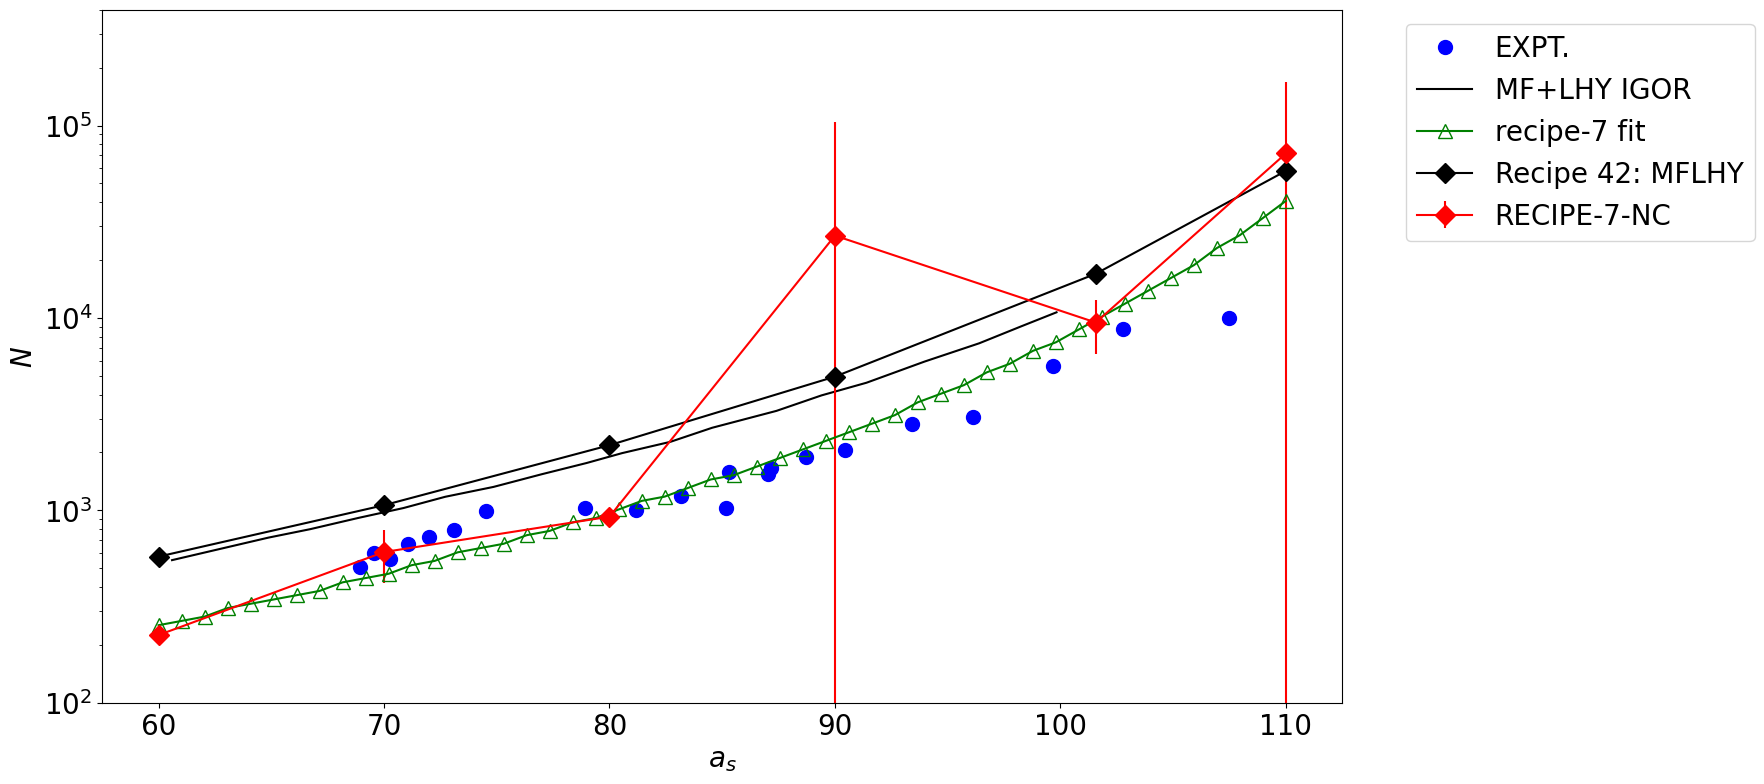

In [75]:

plt.figure(figsize=(16, 9))

def log_func_fit(x, a, b, c):
    return a*x**2 + b*x + c
def func_fit(x, a, b, c):
    return np.exp(log_func_fit(x, a, b, c))
data = np.loadtxt("./experimental-data/combined-critical-atom-number.dat")
sclen_expt = data[:,0]
nc_expt = data[:,1]
popt, pcov = curve_fit(f=log_func_fit, xdata=sclen_expt, ydata=np.log(nc_expt))

plt.plot(sclen_expt, nc_expt, label="EXPT.", ls='', marker='o', color='blue', markersize=10)


mf_data = np.loadtxt("./experimental-data/mean_field_IGOR.dat")
sclen_mf = mf_data[:,0]
nc_mf = mf_data[:,1]
plt.plot(sclen_mf, nc_mf, label="MF+LHY IGOR", color='black', markersize=10)

# load data from file ./results/critical-atom-numbers/recipe-7-nc/functionals_E_N_average_std.dat and plot it
data = np.loadtxt("./results/critical-atom-numbers/recipe-7-nc/functionals_E_N_average_std.dat")
sclen = data[:,0]
nc = data[:,1]
nc_std = data[:,2]
plt.errorbar(sclen, nc, yerr=nc_std, label="RECIPE-7-NC", color='red', ls='-', marker='D', markersize=10)




# same, but for recipe 8
data = np.loadtxt("./results/critical-atom-numbers/recipe-8-nc/functionals_E_N_average_std.dat")
sclen = data[:,0]
nc = data[:,1]
nc_std = data[:,2]
# plot the green error bars, but with the line, with non filled markers
# plt.errorbar(sclen, nc, yerr=nc_std, label="RECIPE-8-NC", color='green', ls='-', marker='^', markersize=10, markerfacecolor='none')


plt.plot(a_s, n_c_best_possible_fit, label="recipe-7 fit", color='green', ls='-', marker='^', markersize=10, markerfacecolor='none')

# Open the output file for writing
# data = np.loadtxt("results/critical-atom-numbers/recipe-7-nc/functionals_E_N_2nd_approach.dat")
# # the header is as follows: a_s <n_c>  err(n_c)  <beta>  err(beta) <gamma>  \n"). Read the data and plot
# sclen = data[:,0]
# nc = data[:,1]
# nc_std = data[:,2]
# plt.errorbar(sclen, nc, yerr=nc_std, label="RECIPE-7-NC-2ND-APPROACH", color='green', ls='-', marker='o', markersize=10)

data = np.loadtxt("./results/critical-atom-numbers/recipe-42-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 42: MFLHY", color='black', marker='D', ls='-', markersize=10)


plt.xlabel(r'$a_s$', fontsize=20)
plt.ylabel(r'$N$', fontsize=20)
plt.legend(loc = "best", bbox_to_anchor=(1.04, 1), fontsize=20)


plt.yscale('log')
plt.ylim(100, 400000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Save the figure into plots folder
plt.savefig(f"plots/critical-atom-number.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"plots/critical-atom-number.png", bbox_inches='tight', dpi=300)
